# Looking at GOCCP Satellite Products for the first time.
Accessed via: 
ftp://ftp.climserv.ipsl.polytechnique.fr/cfmip/GOCCP_v3/3D_CloudFraction/grid_2x2xL40/

In [1]:
import sys
# Add common resources folder to path
sys.path.append("/mnt/mcc-ns9600k/jonahks/git_repos/netcdf_analysis/Common/")
sys.path.append("Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    polyfit, ccrs, LinearRegression, metrics
    )

from functions import (
    masked_average, interpretNS, plot_slf_isotherms, 
    add_weights, process_caliop, process_for_slf,
    noresm_slf_to_df, regress_1d
    )

from classes import CT_SLF_Metric

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
host = os.uname()[1]
if 'jupyter' in host.split('-'): # Check if running on NIRD through the Jupyter Hub
    print('Running through MC2 Jupyter Hub')
    model_dir = '/mnt/mcc-ns9600k/jonahks/'
    os.chdir(model_dir)

else:  # Assume that we're running on a local machine and mounting NIRD
    print('Running on %s, attempting to mount ns9600k/jonahks/ from NIRD' % str(host))
    os.system('fusermount -zu ~/drivemount/')  # unmount first
    os.system('sshfs jonahks@login.nird.sigma2.no:"p/jonahks/" ~/drivemount/')    # Calling mountnird from .bashrc doesn't work
    os.chdir('/home/jonahks/drivemount/')
    save_dir = '~/DATAOUT/'
    save_to = os.path.expanduser(save_dir)

output_dir = 'figures/'
case_dir = 'mnth15runs/'   # inconsistent label compared to jupy_test
mods_dir = 'inp_validation/'
goccp_dir = 'GOCCP_data/2Ddata/'

# Check that each important directory can be accessed:    
access_paths = os.path.exists(mods_dir) and os.path.exists(output_dir) and os.path.exists(mods_dir) and os.path.exists(goccp_dir)
print('Can access all directory paths:', access_paths)

Running through MC2 Jupyter Hub
Can access all directory paths: True


In [3]:
goccp_list = os.listdir(goccp_dir)
goccp_list

['2010', '2011', '2012', '2013', '2009']

In [4]:
goccp_list = os.listdir("%s/%s" % (goccp_dir, "2009"))
goccp_list

['MapLowMidHigh_Phase330m_200910_avg_CFMIP2_sat_3.1.2.nc',
 'MapLowMidHigh330m_200911_avg_CFMIP2_sat_3.1.2.nc',
 'MapLowMidHigh_Phase330m_200907_avg_CFMIP2_sat_3.1.2.nc',
 'MapLowMidHigh330m_200907_avg_CFMIP2_sat_3.1.2.nc',
 'MapLowMidHigh330m_200910_avg_CFMIP2_sat_3.1.2.nc',
 'MapLowMidHigh_Phase330m_200912_avg_CFMIP2_sat_3.1.2.nc',
 'MapLowMidHigh_Phase330m_200906_avg_CFMIP2_sat_3.1.2.nc',
 'MapLowMidHigh_Phase330m_200909_avg_CFMIP2_sat_3.1.2.nc',
 'MapLowMidHigh330m_200908_avg_CFMIP2_sat_3.1.2.nc',
 'MapLowMidHigh330m_200909_avg_CFMIP2_sat_3.1.2.nc',
 'MapLowMidHigh_Phase330m_200911_avg_CFMIP2_sat_3.1.2.nc',
 'MapLowMidHigh_Phase330m_200908_avg_CFMIP2_sat_3.1.2.nc',
 'MapLowMidHigh330m_200912_avg_CFMIP2_sat_3.1.2.nc',
 'MapLowMidHigh330m_200906_avg_CFMIP2_sat_3.1.2.nc']

In [5]:
CloudFraction = xr.open_dataset("%s/%s/%s" % (goccp_dir, "2009", 'MapLowMidHigh330m_200906_avg_CFMIP2_sat_3.1.2.nc'))
CloudFraction_Phase = xr.open_dataset("%s/%s/%s" % (goccp_dir, "2009", 'MapLowMidHigh_Phase330m_200906_avg_CFMIP2_sat_3.1.2.nc'))


In [8]:
CloudFraction

<xarray.Dataset>
Dimensions:     (latitude: 90, longitude: 180, time: 1, toplvl: 3)
Coordinates:
  * longitude   (longitude) float32 -179.0 -177.0 -175.0 ... 175.0 177.0 179.0
  * latitude    (latitude) float32 -89.0 -87.0 -85.0 -83.0 ... 85.0 87.0 89.0
  * toplvl      (toplvl) float32 0.0 0.0 0.0
  * time        (time) datetime64[ns] 2009-06-15T14:04:06.093750016
Data variables:
    cllcalipso  (time, latitude, longitude) float32 ...
    clmcalipso  (time, latitude, longitude) float32 ...
    clhcalipso  (time, latitude, longitude) float32 ...
    cltcalipso  (time, latitude, longitude) float32 ...
    clccalipso  (time, latitude, longitude) float32 ...
Attributes:
    Description:               GOCCP_Map_Low_Mid_High_file
    Date:                      
    Version:                   Prog_version
    Author:                    Gregory CESANA, Helene CHEPFER, LMD/IPSL
    Scientific_contact:        helene.chepfer@lmd.polytechnique.fr
    Technical_support:         gregory.cesana@lmd.polytechnique.fr
    Creationdate:              20180413
    Website:                   http://climserv.ipsl.polytechnique.fr/cfmip-ob...
    References:                Chepfer et al, 2010, The GCM Oriented CALIPSO ...
    history:                   Thu Apr 26 01:23:37 2018: ncra -O /bdd/CFMIP/C...
    NCO:                       "4.5.2"
    nco_openmp_thread_number:  1

In [6]:
CloudFraction_Phase

<xarray.Dataset>
Dimensions:          (cat1: 6, latitude: 90, longitude: 180, time: 1, toplvl: 3)
Coordinates:
  * longitude        (longitude) float32 -179.0 -177.0 -175.0 ... 177.0 179.0
  * latitude         (latitude) float32 -89.0 -87.0 -85.0 ... 85.0 87.0 89.0
  * toplvl           (toplvl) float32 0.0 0.0 0.0
  * time             (time) datetime64[ns] 2009-06-15T14:04:06.093750016
Dimensions without coordinates: cat1
Data variables:
    category         (cat1) |S25 ...
    cllcalipso_liq   (time, latitude, longitude) float32 ...
    clmcalipso_liq   (time, latitude, longitude) float32 ...
    clhcalipso_liq   (time, latitude, longitude) float32 ...
    cltcalipso_liq   (time, latitude, longitude) float32 ...
    cllcalipso_ice   (time, latitude, longitude) float32 ...
    clmcalipso_ice   (time, latitude, longitude) float32 ...
    clhcalipso_ice   (time, latitude, longitude) float32 ...
    cltcalipso_ice   (time, latitude, longitude) float32 ...
    cllcalipso_un    (time, cat1, latitude, longitude) float32 ...
    clmcalipso_un    (time, cat1, latitude, longitude) float32 ...
    clhcalipso_un    (time, cat1, latitude, longitude) float32 ...
    cltcalipso_un    (time, cat1, latitude, longitude) float32 ...
    cllcalipso_RPIC  (time, latitude, longitude) float32 ...
    clmcalipso_RPIC  (time, latitude, longitude) float32 ...
    clhcalipso_RPIC  (time, latitude, longitude) float32 ...
    cltcalipso_RPIC  (time, latitude, longitude) float32 ...
Attributes:
    Description:               GOCCP_Map_Low_Mid_High_Phase_file
    Date:                      
    Version:                   Prog_version
    Author:                    Gregory CESANA, Helene CHEPFER, LMD/IPSL
    Scientific_contact:        helene.chepfer@lmd.polytechnique.fr
    Technical_support:         gregory.cesana@lmd.polytechnique.fr
    Creationdate:              20180413
    Website:                   http://climserv.ipsl.polytechnique.fr/cfmip-ob...
    References:                Chepfer et al, 2010, The GCM Oriented CALIPSO ...
    history:                   Thu Apr 26 01:23:38 2018: ncra -O /bdd/CFMIP/C...
    NCO:                       "4.5.2"
    nco_openmp_thread_number:  1

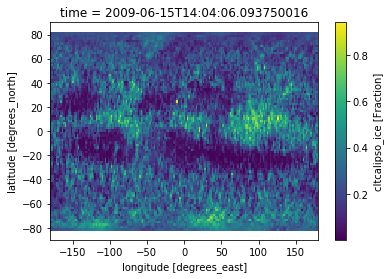

In [7]:
CloudFraction_Phase['cltcalipso_ice'].plot()

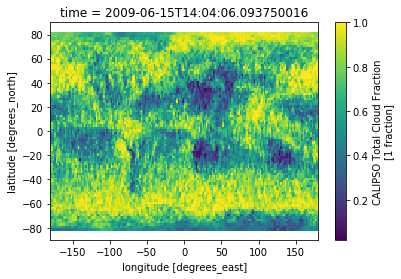

In [9]:
CloudFraction['cltcalipso'].plot()

In [67]:
cldice2d = CloudFraction_Phase['cltcalipso_ice']#.sum(dim=['time','altitude'])
cldice2d

<xarray.DataArray 'cltcalipso_ice' (time: 1, latitude: 90, longitude: 180)>
array([[[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -179.0 -177.0 -175.0 ... 175.0 177.0 179.0
  * latitude   (latitude) float32 -89.0 -87.0 -85.0 -83.0 ... 85.0 87.0 89.0
  * time       (time) datetime64[ns] 2014-03-17
Attributes:
    lon_name:      CALIPSO Total ice Cloud
    units:         Fraction
    cell_methods:  time: mean

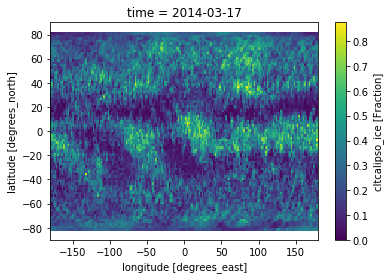

In [68]:
cldice2d.plot()

In [58]:
CloudFraction['alt_mid']

<xarray.DataArray 'alt_mid' (altitude: 40)>
array([ 0.24    ,  0.72    ,  1.2     ,  1.68    ,  2.16    ,  2.64    ,
        3.12    ,  3.6     ,  4.08    ,  4.56    ,  5.04    ,  5.52    ,
        6.      ,  6.48    ,  6.96    ,  7.44    ,  7.92    ,  8.4     ,
        8.88    ,  9.360001,  9.84    , 10.32    , 10.8     , 11.280001,
       11.76    , 12.24    , 12.719999, 13.2     , 13.68    , 14.16    ,
       14.639999, 15.12    , 15.6     , 16.08    , 16.56    , 17.04    ,
       17.52    , 18.      , 18.48    , 18.96    ], dtype=float32)
Dimensions without coordinates: altitude
Attributes:
    long_name:  Middle of the altitude bin
    units:      kilometer
    positive:   up
    axis:       Z

In [22]:
CloudFraction_Temp.temp

<xarray.DataArray 'temp' (temp: 38)>
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37])
Dimensions without coordinates: temp

In [10]:
goccp_test['clcalipso_ice']

<xarray.DataArray 'clcalipso_ice' (time: 1, altitude: 40, latitude: 90, longitude: 180)>
[648000 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -179.0 -177.0 -175.0 ... 175.0 177.0 179.0
  * latitude   (latitude) float32 -89.0 -87.0 -85.0 -83.0 ... 85.0 87.0 89.0
  * time       (time) datetime64[ns] 2014-03-17
Dimensions without coordinates: altitude
Attributes:
    lon_name:      CALIPSO 3D Ice Cloud Phase fraction
    units:         1 fraction
    cell_methods:  time: mean

In [14]:
flattened = goccp_test['clcalipso_ice'].sum(dim=['time','altitude'])

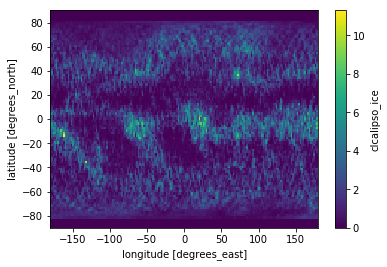

In [17]:
flattened.plot()

In [25]:
tot_test

<xarray.DataArray 'clcalipso_ice' (latitude: 90, longitude: 180)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -179.0 -177.0 -175.0 ... 175.0 177.0 179.0
  * latitude   (latitude) float32 -89.0 -87.0 -85.0 -83.0 ... 85.0 87.0 89.0

In [46]:
tot_test = flattened.copy()

In [47]:
tot_test

<xarray.DataArray 'clcalipso_ice' (latitude: 90, longitude: 180)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -179.0 -177.0 -175.0 ... 175.0 177.0 179.0
  * latitude   (latitude) float32 -89.0 -87.0 -85.0 -83.0 ... 85.0 87.0 89.0

In [55]:
capped_tot_test = tot_test.where(tot_test < 1, 1) # Sets values above 1 to 1, weird convention

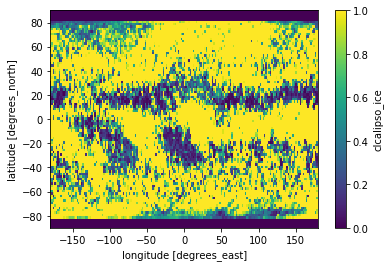

In [56]:
capped_tot_test.plot()

In [33]:
over1 = tot_test > 1

In [39]:
over1

<xarray.DataArray 'clcalipso_ice' (latitude: 90, longitude: 180)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
  * longitude  (longitude) float32 -179.0 -177.0 -175.0 ... 175.0 177.0 179.0
  * latitude   (latitude) float32 -89.0 -87.0 -85.0 -83.0 ... 85.0 87.0 89.0

In [42]:
for i in (np.array(over1).flatten()):
    if i:
        print('Exceeds!')

Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
Exceeds!
E

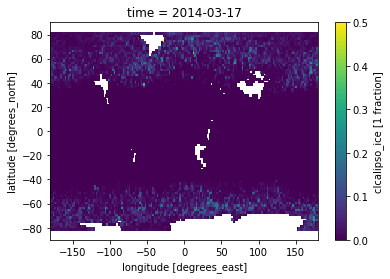

In [18]:
goccp_test['clcalipso_ice'][0,2,:,:].plot()

In [49]:
a = xr.DataArray(np.arange(25).reshape(5, 5), dims=('x', 'y'))

In [50]:
a

<xarray.DataArray (x: 5, y: 5)>
array([[ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14],
       [15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24]])
Dimensions without coordinates: x, y

In [53]:
a.where(a<5, 1)

<xarray.DataArray (x: 5, y: 5)>
array([[0, 1, 2, 3, 4],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1]])
Dimensions without coordinates: x, y